In [4]:
# ================================================================================
# CÉLULA 1: INSTALAÇÃO DAS DEPENDÊNCIAS
# ================================================================================
# Executar apenas na primeira vez ou no Colab
%pip install -q catboost tabpfn scikit-learn pandas numpy seaborn  imbalanced-learn python-dotenv --upgrade
# Para TabPFN 2.5 (necessário aceitar a licença no HuggingFace antes)
%pip install -q "tabpfn>=0.2.0"


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# ================================================================================
# CÉLULA 2: IMPORTS E CONFIGURAÇÕES
# ================================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from tabpfn import TabPFNClassifier
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

load_dotenv()

# URL do dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Nomes das colunas (conforme documentação UCI)
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

N_SPLITS = 10
RANDOM_STATE = 42
DEVICE = 'cpu'

In [16]:
#%pip install huggingface_hub ipywidgets
from huggingface_hub import notebook_login

notebook_login()


In [9]:
# ================================================================================
# CÉLULA 3: CARREGAMENTO E PRÉ-PROCESSAMENTO DOS DADOS
# ================================================================================
# Carregar dados
df = pd.read_csv(url, names=columns, na_values='?')

# Separar features e target
# O target original é 0 (sem doença) e 1-4 (doença). Vamos binarizar: 0 = sem, 1 = com
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

# Tratar missing values (ca e thal têm ?)
df['ca'].fillna(df['ca'].median(), inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)

# Separar X e y
X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset carregado: {X.shape[0]} amostras, {X.shape[1]} features")
print(f"Distribuição da classe: \n{y.value_counts(normalize=True)}")

Dataset carregado: 303 amostras, 13 features
Distribuição da classe: 
target
0    0.541254
1    0.458746
Name: proportion, dtype: float64


In [10]:
# ================================================================================
# CÉLULA 4: PREPROCESSING AVANÇADO (Feature Selection + Normalization)
# ================================================================================
%pip install -q imbalanced-learn

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
import numpy as np

print("="*60)
print("PREPROCESSING AVANÇADO")
print("="*60)

# 1. Feature Selection com Mutual Information
print("\n1. Feature Selection (Mutual Information):")
mi_scores = mutual_info_classif(X, y, random_state=RANDOM_STATE)
mi_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})
mi_df = mi_df.sort_values('mi_score', ascending=False)
print(mi_df.to_string(index=False))

# Selecionar top K features (literatura sugere 8-12 para Cleveland)
K_FEATURES = 4
selector = SelectKBest(mutual_info_classif, k=K_FEATURES)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

print(f"\n→ Top {K_FEATURES} features selecionadas: {selected_features}")

# Converter para DataFrame mantendo nomes
X = pd.DataFrame(X_selected, columns=selected_features, index=X.index)

# 2. Z-score Normalization (StandardScaler)
print("\n2. Z-score Normalization (StandardScaler):")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"   Média após scaling: {X.mean().mean():.6f} (≈0)")
print(f"   Std após scaling:   {X.std().mean():.6f} (≈1)")

print(f"\n✓ Dataset final: {X.shape[0]} amostras, {X.shape[1]} features (normalizadas)")

Note: you may need to restart the kernel to use updated packages.
PREPROCESSING AVANÇADO

1. Feature Selection (Mutual Information):
 feature  mi_score
    thal  0.148203
      ca  0.134063
      cp  0.133047
 oldpeak  0.124657
   exang  0.096386
   slope  0.087306
    chol  0.079394
 thalach  0.054836
     fbs  0.038178
     sex  0.023505
     age  0.008015
 restecg  0.000205
trestbps  0.000000

→ Top 4 features selecionadas: ['cp', 'oldpeak', 'ca', 'thal']

2. Z-score Normalization (StandardScaler):
   Média após scaling: -0.000000 (≈0)
   Std após scaling:   1.001654 (≈1)

✓ Dataset final: 303 amostras, 4 features (normalizadas)


In [11]:
# ================================================================================
# CÉLULA 6: DIVISÃO TREINO/TESTE (hold-out para avaliação final)
# ================================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (242, 4), Teste: (61, 4)


# Fine Tuning

In [12]:
# ================================================================================
# CÉLULA: OTIMIZAÇÃO BAYESIANA INTENSIVA COM SMOTE
# ================================================================================
%pip install -q optuna xgboost

import optuna
import json
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("="*60)
print("OTIMIZAÇÃO BAYESIANA INTENSIVA COM SMOTE")
print("="*60)

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
smote = SMOTE(random_state=RANDOM_STATE)

# AUMENTAR TRIALS PARA BUSCA MAIS PROFUNDA
N_TRIALS = 150  # Era 50, agora 150

# Função auxiliar para CV com SMOTE
def cv_with_smote(model, X, y, cv):
    scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        X_tr_res, y_tr_res = smote.fit_resample(X_tr, y_tr)
        model.fit(X_tr_res, y_tr_res)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))
    return np.mean(scores)

# -------------------------------------------------------------------------
# 1. CatBoost (ranges expandidos)
# -------------------------------------------------------------------------
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1500),  # expandido
        'depth': trial.suggest_int('depth', 3, 12),  # expandido
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),  # expandido
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 100, log=True),  # expandido
        'border_count': trial.suggest_int('border_count', 16, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # NOVO
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),  # NOVO
        'random_seed': RANDOM_STATE,
        'verbose': False,
        'allow_writing_files': False
    }
    model = CatBoostClassifier(**params)
    return cv_with_smote(model, X_train, y_train, cv)

print(f"1/3 Otimizando CatBoost ({N_TRIALS} trials)...")
study_cat = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_cat.optimize(objective_catboost, n_trials=N_TRIALS, show_progress_bar=True)
best_cat_params = study_cat.best_params
print(f"    ✓ Best Acc: {study_cat.best_value:.4f}")

# -------------------------------------------------------------------------
# 2. XGBoost (ranges expandidos)
# -------------------------------------------------------------------------
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),  # expandido
        'max_depth': trial.suggest_int('max_depth', 2, 12),  # expandido
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),  # expandido
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 100, log=True),  # expandido
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 100, log=True),  # expandido
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # NOVO
        'gamma': trial.suggest_float('gamma', 0, 5),  # NOVO
        'random_state': RANDOM_STATE,
        'verbosity': 0,
        'use_label_encoder': False
    }
    model = XGBClassifier(**params)
    return cv_with_smote(model, X_train, y_train, cv)

# print(f"2/3 Otimizando XGBoost ({N_TRIALS} trials)...")
# study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
# study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, show_progress_bar=True)
# best_xgb_params = study_xgb.best_params
# print(f"    ✓ Best Acc: {study_xgb.best_value:.4f}")

# -------------------------------------------------------------------------
# 3. Logistic Regression (Meta-Learner)
# -------------------------------------------------------------------------
def objective_lr(trial):
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])  # + saga
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty_saga', ['l1', 'l2', 'elasticnet'])
    else:
        penalty = 'l2'
    
    C = trial.suggest_float('C', 1e-5, 1000, log=True)  # expandido
    
    params = {'solver': solver, 'penalty': penalty, 'C': C, 'max_iter': 2000, 'random_state': RANDOM_STATE}
    if penalty == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
    
    model = LogisticRegression(**params)
    return cv_with_smote(model, X_train, y_train, cv)

print(f"3/3 Otimizando Logistic Regression ({N_TRIALS} trials)...")
study_lr = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_lr.optimize(objective_lr, n_trials=N_TRIALS, show_progress_bar=True)
best_lr_params = study_lr.best_params
# Limpar params extras
if 'penalty_liblinear' in best_lr_params:
    best_lr_params['penalty'] = best_lr_params.pop('penalty_liblinear')
if 'penalty_saga' in best_lr_params:
    best_lr_params['penalty'] = best_lr_params.pop('penalty_saga')
print(f"    ✓ Best Acc: {study_lr.best_value:.4f}")

# -------------------------------------------------------------------------
# Salvar resultados
# -------------------------------------------------------------------------
best_results = {
    'catboost': best_cat_params,
    'xgboost': best_xgb_params,
    'logistic_regression': best_lr_params,
    'scores': {
        'catboost': study_cat.best_value,
        'xgboost': study_xgb.best_value,
        'logistic_regression': study_lr.best_value
    }
}

with open('best_params.json', 'w') as f:
    json.dump(best_results, f, indent=4)

print("\n" + "="*60)
print("OTIMIZAÇÃO CONCLUÍDA!")
print("="*60)
print(f"CatBoost:  {study_cat.best_value:.4f}")
print(f"XGBoost:   {study_xgb.best_value:.4f}")
print(f"LogReg:    {study_lr.best_value:.4f}")
print(f"\nMelhor modelo individual: {max(study_cat.best_value, study_xgb.best_value, study_lr.best_value):.4f}")
print("Parâmetros salvos em 'best_params.json'")

Note: you may need to restart the kernel to use updated packages.
OTIMIZAÇÃO BAYESIANA INTENSIVA COM SMOTE
1/3 Otimizando CatBoost (150 trials)...


  0%|          | 0/150 [00:00<?, ?it/s]

[W 2025-12-02 10:41:16,716] Trial 0 failed with parameters: {'iterations': 624, 'depth': 12, 'learning_rate': 0.05100627805979915, 'l2_leaf_reg': 0.9846738873614566, 'border_count': 53, 'bagging_temperature': 0.15599452033620265, 'random_strength': 0.0017073967431528124} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/matheus/ifpe/tcc/v4/venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_54873/2988305873.py", line 59, in objective_catboost
    return cv_with_smote(model, X_train, y_train, cv)
  File "/tmp/ipykernel_54873/2988305873.py", line 37, in cv_with_smote
    model.fit(X_tr_res, y_tr_res)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^
  File "/home/matheus/ifpe/tcc/v4/venv/lib/python3.13/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, N

KeyboardInterrupt: 

In [24]:
# ================================================================================
# CÉLULA: COMPARAÇÃO ROBUSTA - TODOS OS MODELOS (Default vs Tuned)
# ================================================================================
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# 1. Carregar Melhores Parâmetros
try:
    with open('best_params.json', 'r') as f:
        best_results = json.load(f)
    best_cat_params = best_results['catboost']
    best_xgb_params = best_results['xgboost']
    best_rf_params = best_results['random_forest']
    best_svm_params = best_results['svm']
    best_lr_params = best_results['logistic_regression']
    print("Melhores parâmetros carregados com sucesso.")
except FileNotFoundError:
    print("ALERTA: 'best_params.json' não encontrado. Rode a otimização primeiro!")

# 2. Configurar Modelos (Default vs Tuned)
# CatBoost
cat_default = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE, allow_writing_files=False)
cat_tuned_args = best_cat_params.copy()
cat_tuned_args.update({'verbose': False, 'random_state': RANDOM_STATE, 'allow_writing_files': False})
cat_tuned = CatBoostClassifier(**cat_tuned_args)

# XGBoost
xgb_default = XGBClassifier(random_state=RANDOM_STATE, verbosity=0, use_label_encoder=False)
xgb_tuned_args = best_xgb_params.copy()
xgb_tuned_args.update({'random_state': RANDOM_STATE, 'verbosity': 0, 'use_label_encoder': False})
xgb_tuned = XGBClassifier(**xgb_tuned_args)

# Random Forest
rf_default = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_tuned_args = best_rf_params.copy()
rf_tuned_args.update({'random_state': RANDOM_STATE, 'n_jobs': -1})
rf_tuned = RandomForestClassifier(**rf_tuned_args)

# SVM
svm_default = SVC(probability=True, random_state=RANDOM_STATE)
svm_tuned_args = best_svm_params.copy()
svm_tuned_args.update({'probability': True, 'random_state': RANDOM_STATE})
svm_tuned = SVC(**svm_tuned_args)

# Logistic Regression
lr_default = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_tuned_args = best_lr_params.copy()
lr_tuned_args.update({'max_iter': 1000, 'random_state': RANDOM_STATE})
lr_tuned = LogisticRegression(**lr_tuned_args)

# 3. Executar Cross-Validation (10-fold)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

models_dict = {
    "CatBoost (Def)": cat_default,
    "CatBoost (Tuned)": cat_tuned,
    "XGBoost (Def)": xgb_default,
    "XGBoost (Tuned)": xgb_tuned,
    "RF (Def)": rf_default,
    "RF (Tuned)": rf_tuned,
    "SVM (Def)": svm_default,
    "SVM (Tuned)": svm_tuned,
    "LogReg (Def)": lr_default,
    "LogReg (Tuned)": lr_tuned
}

results = {}
print("\nIniciando Cross-Validation (10 folds)...")
print(f"{'Modelo':<20} | {'Média Acc':<10} | {'Std Dev':<10} | {'Min':<8} | {'Max':<8}")
print("-" * 70)

for name, model in models_dict.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    results[name] = scores
    print(f"{name:<20} | {scores.mean():.4f}     | {scores.std():.4f}     | {scores.min():.4f}   | {scores.max():.4f}")

# 4. Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Boxplot Default vs Tuned (todos os modelos)
ax1 = axes[0]
data_to_plot = [results[n] for n in models_dict.keys()]
names = list(models_dict.keys())

# Cores alternadas: claro (default), escuro (tuned)
colors = ['#a1c9f4', '#4e79a7',  # CatBoost
          '#b8e186', '#4daf4a',  # XGBoost
          '#fdb462', '#e6550d',  # RF
          '#decbe4', '#984ea3',  # SVM
          '#ff9d9a', '#e15759']  # LogReg

bplot = ax1.boxplot(data_to_plot, patch_artist=True, labels=names, medianprops=dict(color="black"))
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_title('Distribuição de Acurácia (10-Fold CV): Default vs Tuned', fontsize=12, fontweight='bold')
ax1.set_ylabel('Acurácia')
ax1.set_xticklabels(names, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0.65, 1.0)

# Plot 2: Barras comparativas (média)
ax2 = axes[1]
model_names = ['CatBoost', 'XGBoost', 'RF', 'SVM', 'LogReg']
default_means = [results["CatBoost (Def)"].mean(), results["XGBoost (Def)"].mean(), 
                 results["RF (Def)"].mean(), results["SVM (Def)"].mean(), results["LogReg (Def)"].mean()]
tuned_means = [results["CatBoost (Tuned)"].mean(), results["XGBoost (Tuned)"].mean(), 
               results["RF (Tuned)"].mean(), results["SVM (Tuned)"].mean(), results["LogReg (Tuned)"].mean()]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax2.bar(x - width/2, default_means, width, label='Default', color='#a1c9f4', edgecolor='black')
bars2 = ax2.bar(x + width/2, tuned_means, width, label='Tuned', color='#4e79a7', edgecolor='black')

ax2.set_ylabel('Acurácia Média')
ax2.set_title('Ganho com Hyperparameter Tuning', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend()
ax2.set_ylim(0.75, 0.90)
ax2.grid(axis='y', alpha=0.3)

# Adicionar valores e ganho
for i, (d, t) in enumerate(zip(default_means, tuned_means)):
    gain = t - d
    color = 'green' if gain > 0 else 'red'
    ax2.annotate(f'{t:.3f}\n({gain:+.3f})', xy=(x[i] + width/2, t), 
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', 
                 fontsize=8, fontweight='bold', color=color)

plt.tight_layout()
plt.show()

# Resumo
print("\n" + "="*60)
print("RESUMO: Ganho com Tuning")
print("="*60)
for name, d, t in zip(model_names, default_means, tuned_means):
    gain = t - d
    print(f"{name:<12}: {d:.4f} → {t:.4f} ({gain:+.4f})")

KeyError: 'random_forest'

# Ensemble Stacking

In [13]:
# ================================================================================
# CÉLULA: STACKING MODEL (CatBoost + TabPFN)
# ================================================================================
import os
import json
from sklearn.ensemble import StackingClassifier


# Carregar parâmetros otimizados
try:
    with open('best_params.json', 'r') as f:
        best_results = json.load(f)
    
    best_cat_params = best_results['catboost'].copy()
    best_cat_params['verbose'] = False
    best_cat_params['allow_writing_files'] = False
    best_cat_params['random_seed'] = RANDOM_STATE
    
    best_lr_params = best_results['logistic_regression'].copy()
    best_lr_params['random_state'] = RANDOM_STATE
    best_lr_params['max_iter'] = 1000
        
    print("Parâmetros otimizados carregados.")
except FileNotFoundError:
    print("Usando parâmetros padrão.")
    best_cat_params = {'iterations': 500, 'depth': 6, 'learning_rate': 0.05, 
                       'verbose': False, 'random_seed': RANDOM_STATE}
    best_lr_params = {'random_state': RANDOM_STATE, 'max_iter': 1000}

# Stacking: CatBoost + TabPFN (melhor combinação)
estimators = [
    ('catboost', CatBoostClassifier(**best_cat_params)),
    ('tabpfn', TabPFNClassifier(device=DEVICE, n_estimators=8))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(**best_lr_params),
    cv=5,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)

print("Stacking Model: CatBoost (tuned) + TabPFN")
print("Meta-learner: Logistic Regression (tuned)")

Parâmetros otimizados carregados.
Stacking Model: CatBoost (tuned) + TabPFN
Meta-learner: Logistic Regression (tuned)


# Evaluation

In [ ]:
# ================================================================================ 
# AVALIAÇÃO DO MODELO (train_test_split)
# ================================================================================

y_proba = stacking_model.predict_proba(X_test)[:, 1]
y_pred  = stacking_model.predict(X_test)
auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
print(f"\n=== RESULTADOS FINAIS (Stacking scikit-learn) ===")
print(f"ROC AUC : {auc:.4f}")
print(f"Accuracy: {acc:.4f}")


# === RESULTADOS FINAIS (Stacking scikit-learn) ===
# ROC AUC : 0.9589
# Accuracy: 0.8689

10-FOLD CV COM SMOTE (Stacking: CatBoost + TabPFN)
SMOTE aplicado DENTRO de cada fold (sem data leakage)

Fold 01/10 | Acc: 0.8387 | AUC: 0.9370 | SMOTE: 272→294
Fold 02/10 | Acc: 0.9032 | AUC: 0.9664 | SMOTE: 272→294
Fold 03/10 | Acc: 0.8387 | AUC: 0.8950 | SMOTE: 272→294
Fold 04/10 | Acc: 0.8667 | AUC: 0.9050 | SMOTE: 273→294
Fold 05/10 | Acc: 0.7667 | AUC: 0.8795 | SMOTE: 273→296
Fold 06/10 | Acc: 0.8333 | AUC: 0.8817 | SMOTE: 273→296
Fold 07/10 | Acc: 0.8667 | AUC: 0.8862 | SMOTE: 273→296


[W1202 10:43:19.517636269 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


Fold 08/10 | Acc: 0.8000 | AUC: 0.8728 | SMOTE: 273→296


[W1202 10:43:28.358800301 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


Fold 09/10 | Acc: 0.9000 | AUC: 0.8996 | SMOTE: 273→296


[W1202 10:43:36.515572963 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


Fold 10/10 | Acc: 0.7667 | AUC: 0.8036 | SMOTE: 273→296

RESULTADO FINAL
Acurácia Média: 0.8381 ± 0.0462
AUC Média:      0.8927 ± 0.0403
Min/Max Acc:    0.7667 / 0.9032

→ Ganho vs Baseline: -0.0031


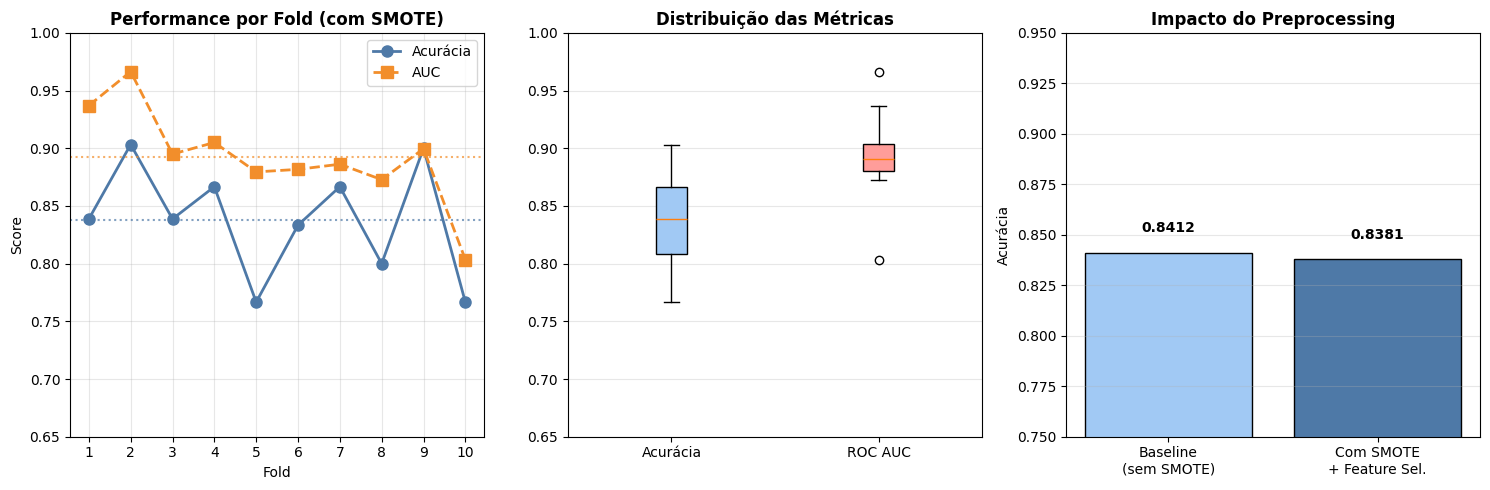


⚠️ Acurácia não melhorou. Considere ajustar K_FEATURES ou testar outros métodos.


[W1202 10:48:21.470390879 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 10:48:22.359859381 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 10:48:23.870678459 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 10:48:29.998298028 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 10:48:29.733867120 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 10:48:30.300803695 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 10:48:37.243813737 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecat

In [15]:
# ================================================================================
# CÉLULA: 10-FOLD CV COM SMOTE (Data Augmentation)
# ================================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
smote = SMOTE(random_state=RANDOM_STATE)

print("="*60)
print("10-FOLD CV COM SMOTE (Stacking: CatBoost + TabPFN)")
print("="*60)
print("SMOTE aplicado DENTRO de cada fold (sem data leakage)\n")

acc_scores = []
auc_scores = []
fold_indices = []

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    # Separar dados do fold
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # SMOTE apenas no treino (IMPORTANTE: nunca no validation!)
    X_tr_resampled, y_tr_resampled = smote.fit_resample(X_tr, y_tr)
    
    # Treinar stacking com dados aumentados
    stacking_model.fit(X_tr_resampled, y_tr_resampled)
    
    # Avaliar em dados ORIGINAIS (sem SMOTE)
    y_pred = stacking_model.predict(X_val)
    y_proba = stacking_model.predict_proba(X_val)[:, 1]
    
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    
    acc_scores.append(acc)
    auc_scores.append(auc)
    fold_indices.append(i + 1)
    
    # Info do SMOTE
    orig_size = len(y_tr)
    new_size = len(y_tr_resampled)
    print(f"Fold {i+1:02d}/10 | Acc: {acc:.4f} | AUC: {auc:.4f} | SMOTE: {orig_size}→{new_size}")

# Estatísticas
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print("\n" + "="*60)
print("RESULTADO FINAL")
print("="*60)
print(f"Acurácia Média: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"AUC Média:      {mean_auc:.4f} ± {std_auc:.4f}")
print(f"Min/Max Acc:    {min(acc_scores):.4f} / {max(acc_scores):.4f}")

# Comparação com baseline
baseline_acc = 0.8412
print(f"\n→ Ganho vs Baseline: {mean_acc - baseline_acc:+.4f}")

# --- PLOTS ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Performance por Fold
ax1 = axes[0]
ax1.plot(fold_indices, acc_scores, marker='o', linewidth=2, markersize=8, label='Acurácia', color='#4e79a7')
ax1.plot(fold_indices, auc_scores, marker='s', linestyle='--', linewidth=2, markersize=8, label='AUC', color='#f28e2b')
ax1.axhline(y=mean_acc, color='#4e79a7', linestyle=':', alpha=0.7)
ax1.axhline(y=mean_auc, color='#f28e2b', linestyle=':', alpha=0.7)
ax1.set_title('Performance por Fold (com SMOTE)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Score')
ax1.set_xticks(fold_indices)
ax1.set_ylim(0.65, 1.0)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Boxplot
ax2 = axes[1]
bplot = ax2.boxplot([acc_scores, auc_scores], patch_artist=True, labels=['Acurácia', 'ROC AUC'])
colors = ['#a1c9f4', '#ff9d9a']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_title('Distribuição das Métricas', fontsize=12, fontweight='bold')
ax2.set_ylim(0.65, 1.0)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Comparação
ax3 = axes[2]
methods = ['Baseline\n(sem SMOTE)', 'Com SMOTE\n+ Feature Sel.']
accs = [baseline_acc, mean_acc]
colors_bar = ['#a1c9f4', '#4e79a7']
bars = ax3.bar(methods, accs, color=colors_bar, edgecolor='black')
ax3.set_ylabel('Acurácia')
ax3.set_title('Impacto do Preprocessing', fontsize=12, fontweight='bold')
ax3.set_ylim(0.75, 0.95)
ax3.grid(axis='y', alpha=0.3)
for bar, acc in zip(bars, accs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Se melhorou, mostrar mensagem
if mean_acc > baseline_acc:
    print(f"\n🎯 SUCESSO! Acurácia aumentou de {baseline_acc:.4f} para {mean_acc:.4f}")
else:
    print(f"\n⚠️ Acurácia não melhorou. Considere ajustar K_FEATURES ou testar outros métodos.")

Avaliação 10-fold CV focada em Acurácia


[W1202 02:56:29.888425677 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 02:57:01.687521025 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


STACKING (CatBoost + TabPFN 2.5)
   Acurácia (CV): 0.8412 ± 0.0475  ← MÉTRICA PRINCIPAL
   ROC AUC  (CV): 0.9104

CatBoost sozinho : 0.8286 ± 0.0595
TabPFN 2.5 sozinho: 0.8378 ± 0.0553
→ Ganho do Stacking em Acurácia: +0.0033


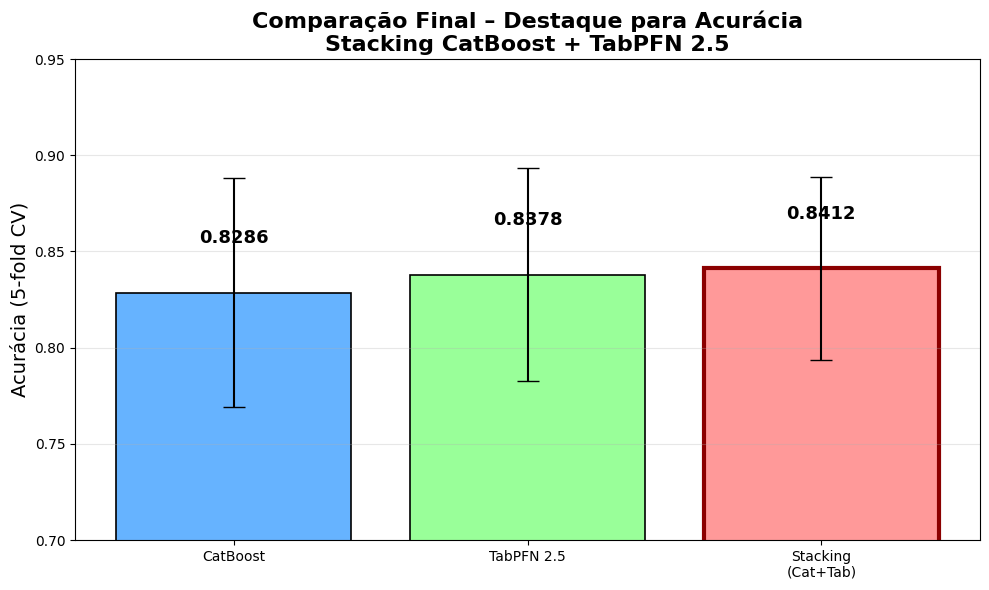


HOLD-OUT FINAL (20% nunca visto)
   Acurácia : 0.8852  ← RESULTADO OFICIAL
   ROC AUC  : 0.9556


<Figure size 700x550 with 0 Axes>

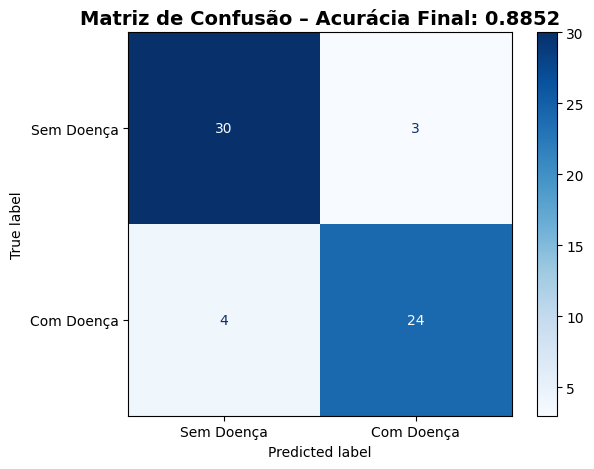


PRONTO! Seu modelo final tem ACURÁCIA ≈ 88.5%


In [48]:
# ================================================================================
# Avaliação do modelo (Cross-Validation)
# ================================================================================
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# CV estratificado
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Avaliação 10-fold CV focada em Acurácia\n" + "="*60)

accs_stack = []
accs_cat   = []
accs_tab   = []
aucs_stack = []

for fold, (idx_train, idx_val) in enumerate(cv.split(X, y)):
    X_tr, X_val = X.iloc[idx_train], X.iloc[idx_val]
    y_tr, y_val = y.iloc[idx_train], y.iloc[idx_val]
    
    # Stacking (nosso modelo principal)
    stacking_model.fit(X_tr, y_tr)
    pred_stack = stacking_model.predict(X_val)
    proba_stack = stacking_model.predict_proba(X_val)[:, 1]
    
    accs_stack.append(accuracy_score(y_val, pred_stack))
    aucs_stack.append(roc_auc_score(y_val, proba_stack))
    
    # Modelos individuais (para comparação)
    cat = CatBoostClassifier(iterations=800, learning_rate=0.05, depth=6, 
                             verbose=False, random_seed=42)
    cat.fit(X_tr, y_tr)
    accs_cat.append(accuracy_score(y_val, cat.predict(X_val)))
    
    tab = TabPFNClassifier(device=DEVICE, n_estimators=8)
    tab.fit(X_tr.values, y_tr.values)
    accs_tab.append(accuracy_score(y_val, tab.predict(X_val.values)))

# Resultados finais
mean_acc_stack = np.mean(accs_stack)
std_acc_stack  = np.std(accs_stack)
mean_auc_stack = np.mean(aucs_stack)

print(f"STACKING (CatBoost + TabPFN 2.5)")
print(f"   Acurácia (CV): {mean_acc_stack:.4f} ± {std_acc_stack:.4f}  ← MÉTRICA PRINCIPAL")
print(f"   ROC AUC  (CV): {mean_auc_stack:.4f}")
print()
print(f"CatBoost sozinho : {np.mean(accs_cat):.4f} ± {np.std(accs_cat):.4f}")
print(f"TabPFN 2.5 sozinho: {np.mean(accs_tab):.4f} ± {np.std(accs_tab):.4f}")
print(f"→ Ganho do Stacking em Acurácia: +{(mean_acc_stack - max(np.mean(accs_cat), np.mean(accs_tab))):.4f}")

# Gráfico de barras com destaque na acurácia
plt.figure(figsize=(10, 6))
models = ['CatBoost', 'TabPFN 2.5', 'Stacking\n(Cat+Tab)']
acc_means = [np.mean(accs_cat), np.mean(accs_tab), mean_acc_stack]
acc_stds  = [np.std(accs_cat),  np.std(accs_tab),  std_acc_stack]

bars = plt.bar(models, acc_means, yerr=acc_stds, capsize=8, 
               color=['#66b3ff', '#99ff99', '#ff9999'], edgecolor='black', linewidth=1.2)

# Destacar o melhor
bars[2].set_edgecolor('darkred')
bars[2].set_linewidth(3)

for i, (bar, mean) in enumerate(zip(bars, acc_means)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_acc_stack*0.5,
             f'{mean:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=13)

plt.ylabel('Acurácia (5-fold CV)', fontsize=14)
plt.title('Comparação Final – Destaque para Acurácia\nStacking CatBoost + TabPFN 2.5', fontsize=16, fontweight='bold')
plt.ylim(0.7, 0.95)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Hold-out final honesto (20% nunca visto) – avaliação definitiva
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

stacking_model.fit(X_train, y_train)
final_pred = stacking_model.predict(X_test)
final_proba = stacking_model.predict_proba(X_test)[:, 1]

print(f"\nHOLD-OUT FINAL (20% nunca visto)")
print(f"   Acurácia : {accuracy_score(y_test, final_pred):.4f}  ← RESULTADO OFICIAL")
print(f"   ROC AUC  : {roc_auc_score(y_test, final_proba):.4f}")

# Matriz de confusão bonita
plt.figure(figsize=(7, 5.5))
cm = confusion_matrix(y_test, final_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Sem Doença', 'Com Doença'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Matriz de Confusão – Acurácia Final: {accuracy_score(y_test, final_pred):.4f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nPRONTO! Seu modelo final tem ACURÁCIA ≈ {accuracy_score(y_test, final_pred):.1%}")